# Goal

This notebook tests the PI code to ensure it runs smoothly and provides reasonable output. A full QC of the code is provided in "verify_pi".

# Setup

In [1]:
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
# load PI calculation module
from tcpyPI import pi, cape

In [2]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data and Code

In [3]:
# data location
dat_loc='../data/sample_data.nc'

In [4]:
# load and view netcdf file
ds = xr.open_dataset(dat_loc)
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, month: 12, p: 31)
Coordinates:
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 40.0 30.0 20.0 10.0
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    lsm      (lat, lon) float64 ...
    sst      (month, lat, lon) float64 ...
    msl      (month, lat, lon) float64 ...
    t        (month, p, lat, lon) float64 ...
    q        (month, p, lat, lon) float64 ...
    Vmax     (month, lat, lon) float64 ...
    To       (month, lat, lon) float64 ...
    Pmin     (month, lat, lon) float64 ...
    LNB      (month, lat, lon) float64 ...
    PI_flag  (month, lat, lon) float64 ...

### Check Data Load

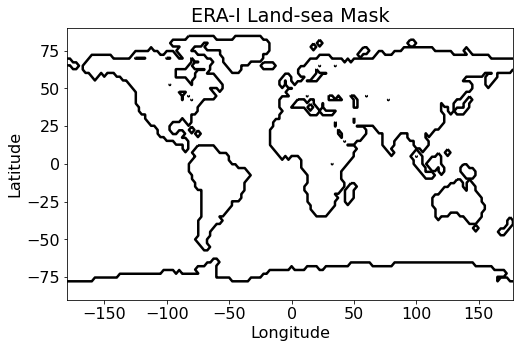

In [5]:
# view the land-sea mask as a sanity check of our data loading
plt.figure(figsize=(8,5))
plt.contour(ds.lon,ds.lat,ds.lsm,[0.1,],colors='k',linewidths=2.5)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title(ds.lsm.standard_name)
plt.show()

# Test CAPE calculation

### Grab one profile from the NA and plot

In [6]:
# choose a location and month
want_lat=10
want_lon=-180
want_mon=9
# find the index of the profile
xi=np.where(ds.lon==want_lon)[0][0]
yi=np.where(ds.lat==want_lat)[0][0]
moni=int(want_mon)
# moni,yi,xi=0,19,76
# get the profile and input values
p1=np.asarray(ds.p)
t1=np.asarray(ds.t.isel(lat=yi,lon=xi,month=moni))
q1=np.asarray(ds.q.isel(lat=yi,lon=xi,month=moni))
sst1=np.asarray(ds.sst.isel(lat=yi,lon=xi,month=moni))
msl1=np.asarray(ds.msl.isel(lat=yi,lon=xi,month=moni))
# get the output values
to1=np.asarray(ds.To.isel(lat=yi,lon=xi,month=moni))
pi1=np.asarray(ds.Vmax.isel(lat=yi,lon=xi,month=moni))
pmin1=np.asarray(ds.Pmin.isel(lat=yi,lon=xi,month=moni))
lnb1=np.asarray(ds.LNB.isel(lat=yi,lon=xi,month=moni))
flag1=np.asarray(ds.PI_flag.isel(lat=yi,lon=xi,month=moni))

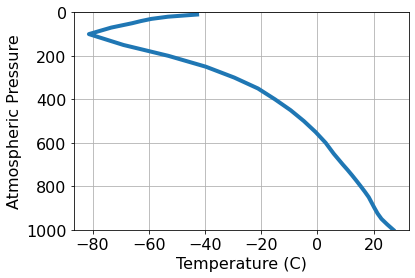

In [7]:
plt.figure()
plt.plot(t1,p1,lw=4)
plt.ylim([0,1000])
plt.gca().invert_yaxis()
#plt.yscale('log')
plt.ylabel(ds.p.standard_name)
plt.xlabel('Temperature (C)')
plt.grid()
plt.show()

In [8]:
# initial parcel characteristics
TP=t1[0]+273.15;
PP=np.min([p1[0],1000.0])
ES0=6.112*np.exp(17.67*t1[0]/(243.5+t1[0]))
RP=0.622*ES0/(PP-ES0)
# convert to the proper units for CAPE module
t1k=t1+273.15
q1gg=q1*0.001

In [9]:
(CAPED,TOB,LNB,IFLAG)=cape(TP,RP,PP,t1k,q1gg,p1,ascent_flag=0,ptop=50,miss_handle=0)

In [10]:
(VMAX,PMIN,IFL,TO,LNB)=pi(sst1,msl1,p1,t1,q1,CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8,miss_handle=0)

### PI module run time

Average Module Runtime = 0.0007244467735290528


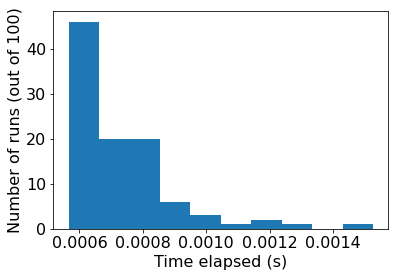

In [11]:
import time
nruns=100
# time the loop
time_check=np.zeros((nruns,))
for i in range(nruns):
    start = time.time()
    check=pi(sst1,msl1,p1,t1,q1,CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8,miss_handle=0)
    end = time.time()
    time_check[i,]=end - start
    
print('Average Module Runtime = '+str(np.mean(time_check)))
plt.figure()
plt.hist(time_check)
plt.ylabel('Number of runs (out of 100)')
plt.xlabel('Time elapsed (s)')
plt.show()

### Compare output with MATLAB calculations

In [12]:
print('-------PYTHON PI-------')
print('VMAX_check = '+str(VMAX))
print('PMIN_check = '+str(PMIN))
print('To_check = '+str(TO))
print('LNB_check = '+str(LNB))
print('IFL_check = '+str(IFL))

print('-------MATLAB PI-------')
print('VMAX = '+str(pi1))
print('PMIN = '+str(pmin1))
print('To = '+str(to1))
print('LNB = '+str(lnb1))
print('Flag = '+str(flag1))

-------PYTHON PI-------
VMAX_check = 80.93490863320275
PMIN_check = 884.2852067162651
To_check = 196.1764039256962
LNB_check = 83.7545053531184
IFL_check = 1
-------MATLAB PI-------
VMAX = 80.94025179690918
PMIN = 884.267888061597
To = 196.17747790897812
LNB = 83.75044975211635
Flag = 1.0


The Python code appears to be reproducing the MATLAB CAPE and PI outputs. A full quality control is performed in the verify_pi.ipynb notebook.